In [1]:
import os
import fitsio
import desimodel
import astropy
import pandas                as     pd
import pylab                 as     pl
import numpy                 as     np
import astropy.io.fits       as     fits
import matplotlib.pyplot     as     plt

from   datetime              import datetime
from   astropy.table         import Table, vstack, join
from   astropy.coordinates   import Angle, SkyCoord
from   astropy               import units as u

from   desimodel.footprint   import is_point_in_desi
from   desimodel             import io
from   desitarget.geomask    import circles
from   desitarget.targetmask import desi_mask, obsconditions
from   astropy.coordinates   import SkyCoord
from   astropy.table         import Table
from   pathlib               import Path
from   desimodel.focalplane  import get_tile_radius_deg

In [2]:
np.random.seed(seed=314)

Potential addition: 'Stars were removed from the sample used to compute the number counts using SExtractor’s CLASS_STAR parameter with a threshold of 0.85'

In [3]:
def get_hildebrandt(field='D2'):
    # SXDS:  (02:18:00.00, −05:00:00.00), D1 encompassed by W1.  
    return  Table.read('/global/cscratch1/sd/mjwilson/DESILBG/Hildebrandt/{}.cat'.format(field))

In [4]:
def get_goldrush():
    # https://arxiv.org/pdf/1704.06004.pdf    
    return Table.read('/global/homes/m/mjwilson/DESILBG/target/proposals/goldrush/goldrush_mizukizs.fits')

In [5]:
def get_laes():
    # https://arxiv.org/pdf/0801.4017.pdf
    dat   = pd.read_csv('/global/homes/m/mjwilson/DESILBG/target/proposals/sxds_laes.txt', sep='\s+', comment='#')
    
    dat.drop(dat.columns[list(np.arange(7, 20, 1))], axis=1, inplace=True)
    
    dat.columns = ['Row', 'Name', 'RA', 'DEC', 'None', 'Velocity', 'Redshift']
    dat['RA']   = [Angle(x).deg for x in dat['RA']]
    dat['DEC']  = [Angle(x[:-1] + '.0s').deg for x in dat['DEC']]
    
    return  dat

In [6]:
def get_vvds():
    # https://cesam.lam.fr/vvds/vvds_download.php
    dat = pd.read_csv('/global/cscratch1/sd/mjwilson/VVDS/cesam_vvds_spF02_DEEP_Full.txt', sep='\s+')

    # Cut.
    dat = dat[dat['Z'] < 9.0]
    
    return dat

In [7]:
def get_splash():
    dat = Table.read('/global/cscratch1/sd/mjwilson/SPLASH/SPLASH_SXDF_Mehta+_v1.6.fits')
    
    return dat

In [8]:
def get_clauds(imaging_bit=1, field='COSMOS', release='February2021'):
    fields           = ['COSMOS', 'DEEP_2', 'ELAIS', 'XMM_LSS']
    clauds           = {}
        
    assert field in fields
        
    areas            = {}
    areas['COSMOS']  = {'u': 4.41, 'uS': 4.20, 'g': 7.84,  'r': 7.84,  'i': 7.84,  'z': 7.84,  'y': 7.84}
    areas['XMM-LSS'] = {'u': 0.00, 'uS': 6.80, 'g': 6.38,  'r': 6.38,  'i': 6.38,  'z': 6.38,  'y': 6.38}
    areas['DEEP2-3'] = {'u': 3.70, 'uS': 0.00, 'g': 6.11,  'r': 6.11,  'i': 6.11,  'z': 6.11,  'y': 6.11}
    areas['ELAIS-N'] = {'u': 6.49, 'uS': 0.00, 'g': 10.68, 'r': 10.68, 'i': 10.68, 'z': 10.68, 'y': 10.68}

    for key in areas.keys():
        if imaging_bit == 1:
            del areas[key]['uS']
    
        elif imaging_bit == 2:
            del areas[key]['u']

    if release == 'October2020':
        raise NotImplementedError()
        
    else:   
        clauds[field] = Table.read('/global/cscratch1/sd/mjwilson/clauds/{}/{}_v9_v210212.fits'.format(release, field))
    
    # Bright star mask & has newer u band data: [HSC, u, Us, J, VirCAM, UDEEP] for FLAG_FIELD_BINARY (imaging_bit). 
    clauds[field] = clauds[field][(clauds[field]['MASK'] == 0) & clauds[field]['FLAG_FIELD_BINARY'][:,imaging_bit] == True]

    # Randomise the rows for security. 
    indices       = np.arange(len(clauds[field]))
    randomised    = np.random.choice(indices, size=len(indices), replace=False)
    
    return  clauds[field][randomised], areas[field]

In [9]:
def get_cfhtls_wide():
    # https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/megapipe/cfhtls/uc.html; I-band detected. 
    # u-band limit of 25.2 in the wide field.
    filename = '/global/cscratch1/sd/mjwilson/CFHTLS/W.I.con.cat'     
    
    names    = []

    with open(filename, 'r') as fh:
      for curline in fh:
         if curline.startswith("#"):
              words = curline.split()
              names.append(words[2])

         else:
            break
    
    fh.close()
    
    dat   = pd.read_csv(filename, sep='\s+', comment='#', names=names)
                        
    return  dat

In [10]:
tile_radius = get_tile_radius_deg()
tiles       = Table(io.load_tiles())

In [11]:
# hiz  = laigle()

In [12]:
# kids = get_kids()

In [13]:
# splash = get_splash()

In [14]:
# splash_zspec = splash[splash['ZSPEC'] > 0.]

In [15]:
# hilde  = get_hildebrandt()

In [16]:
# grush  = get_goldrush()

In [17]:
# laes   = get_laes()

In [18]:
# cfhtls = get_cfhtls_wide()

In [19]:
# vvds = get_vvds()

In [20]:
clauds, area = get_clauds(imaging_bit=1, field='COSMOS')

In [21]:
# Old length: 2582606
clauds

ID,RA,DEC,TRACT,PATCH,MASK,FLAG_FIELD,FLAG_FIELD_BINARY [5],A_WORLD,B_WORLD,KRON_RADIUS,THETA_WORLD,ELONGATION,ELLIPTICITY,EB_V,FWHM_WORLD_HSC_I,MU_MAX_HSC_I,CLASS_STAR_HSC_I,FLUX_RADIUS_0.25_HSC_I,FLUX_RADIUS_0.5_HSC_I,FLUX_RADIUS_0.75_HSC_I,FUV,NUV,u,uS,g,r,i,z,y,Yv,J,H,Ks,FUV_err,NUV_err,u_err,uS_err,g_err,r_err,i_err,z_err,y_err,Yv_err,J_err,H_err,Ks_err,MAG_APER_2s_u,MAG_APER_2s_uS,MAG_APER_2s_g,MAG_APER_2s_r,MAG_APER_2s_i,MAG_APER_2s_z,MAG_APER_2s_y,MAG_APER_2s_Yv,MAG_APER_2s_J,MAG_APER_2s_H,MAG_APER_2s_Ks,MAGERR_APER_2s_u,MAGERR_APER_2s_uS,MAGERR_APER_2s_g,MAGERR_APER_2s_r,MAGERR_APER_2s_i,MAGERR_APER_2s_z,MAGERR_APER_2s_y,MAGERR_APER_2s_Yv,MAGERR_APER_2s_J,MAGERR_APER_2s_H,MAGERR_APER_2s_Ks,MAG_APER_3s_u,MAG_APER_3s_uS,MAG_APER_3s_g,MAG_APER_3s_r,MAG_APER_3s_i,MAG_APER_3s_z,MAG_APER_3s_y,MAG_APER_3s_Yv,MAG_APER_3s_J,MAG_APER_3s_H,MAG_APER_3s_Ks,MAGERR_APER_3s_u,MAGERR_APER_3s_uS,MAGERR_APER_3s_g,MAGERR_APER_3s_r,MAGERR_APER_3s_i,MAGERR_APER_3s_z,MAGERR_APER_3s_y,MAGERR_APER_3s_Yv,MAGERR_APER_3s_J,MAGERR_APER_3s_H,MAGERR_APER_3s_Ks,OFFSET_MAG_2s,OFFSET_MAG_3s,CONTEXT,MAG_ABS_FUV,MAG_ABS_NUV,MAG_ABS_u,MAG_ABS_uS,MAG_ABS_g,MAG_ABS_r,MAG_ABS_i,MAG_ABS_z,MAG_ABS_y,MAG_ABS_Yv,MAG_ABS_J,MAG_ABS_H,MAG_ABS_Ks,Z_SPEC,Z_BEST,Z_BEST68_LOW,Z_BEST68_HIGH,NBAND_USED,CHI_BEST,CHI_STAR,CHI_QSO,MOD_BEST,MOD_STAR,MOD_QSO,Z_ML,Z_ML68_LOW,Z_ML68_HIGH,Z_SEC,Z_QSO,Z_BC03,ZPHOT,MOD_BEST_BC03,AGE_BEST,EBV_BEST,EXTLAW_BEST,AGE_MED,MASS_MED,MASS_BEST,MASS_INF,MASS_SUP,SFR_MED,SFR_BEST,SFR_INF,SFR_SUP,SSFR_MED,SSFR_BEST,SSFR_INF,SSFR_SUP,LUM_NUV_BEST,LUM_R_BEST,LUM_K_BEST,OBJ_TYPE,COMPACT,STAR_FORMING,NrK,IRX_NrK,LIR_NrK,SFR_NrK
int64,float64,float64,int64,bytes3,int16,int16,bool,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64
3154335,149.13232433290514,2.5546504606039897,9812,"2,6",0,7,True .. False,6.432973e-05,4.1858057e-05,4.0,65.04344,1.5367969,0.34929597,0.019528131582531447,0.00024061684,25.891245,0.356922,1.0085294,1.4280493,1.7852052,-99.0,-99.0,-99.094,28.809,29.315,27.493,26.726,27.176,27.869,-99.024,-99.017,-99.011,-99.007,-99.0,-99.0,-99.0,1.811,1.439,0.368,0.235,0.554,2.562,1000.0,1000.0,1000.0,1000.0,99.0,28.899778,29.386625,27.545229,26.76477,27.20536,27.893911,-99.0,-99.0,-99.0,-99.0,-99.0,1.8105469,1.4394531,0.36767578,0.23498535,0.5541992,2.5625,1000.0,1000.0,1000.0,1000.0,99.0,99.0,99.0,29.40419,26.695395,28.843664,99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,3.0585938,0.3310547,3.7519531,-99.0,1000.0,1000.0,1000.0,1000.0,0.0,-1.666145738744851,2046.0,-18.286,-17.828,-144.694,-144.851,-144.744,-145.078,-145.358,-145.578,-145.693,-145.729,-145.855,-146.046,-145.886,3.2816,3.2816,-99.0,-99.0,10,1.50695,1.32878,0.527892,7,96,18,-99.0,-99.0,-99.0,-99.0,3.36,3.2816,3.2816,7,180529000.0,0.4,1,499925000.0,9.67309,9.59731,8.88242,10.515,1.19656,1.46308,0.542404,1.98557,-8.47592,-8.13423,-8.90557,-7.99327,10.319,9.87009,8.84008,0.0,0,0,46.35665456424919,30.3961676564

In [22]:
print('Target density of clauds galaxies per sq. deg. is {:.2f}'.format(len(clauds) / area['u']))

Target density of clauds galaxies per sq. deg. is 625272.11


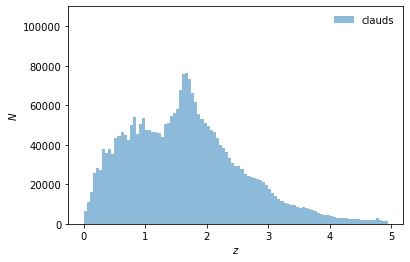

In [23]:
bins = np.arange(0.0, 5.0, 0.05)

pl.hist(clauds['Z_BEST'], bins=bins, alpha=0.5, label='clauds')

pl.ylim(0.0, 1.1e5)

pl.xlabel(r'$z$')
pl.ylabel(r'$N$')

pl.legend(frameon=False)

In [24]:
isin, indx = is_point_in_desi(tiles, clauds['RA'], clauds['DEC'], radius=None, return_tile_index=True)

In [25]:
tileids = np.unique(indx)

In [26]:
tileids

array([  828,  2826,  3754,  5656,  5752,  5753,  7750, 11747, 13744,
       13745])

In [27]:
# u-band imaging restricted.
cra      = np.median(clauds['RA'])
cdec     = np.median(clauds['DEC'])

trad     = tile_radius

In [28]:
# (10:00:59.50, 02:13:53.06)
hsc_cosmos = SkyCoord('10h00m59.5s', '+02d13m53.06s', frame='icrs')

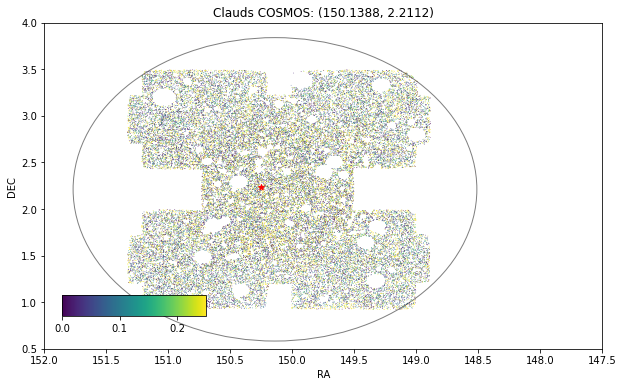

In [30]:
fig, ax  = plt.subplots(1, 1, figsize=(10, 6)) 
im       = pl.scatter(clauds['RA'][::50], clauds['DEC'][::50], c=clauds['u_err'][::50], marker='.', s=2, lw=0.0, vmin=0.0, vmax=.25)

pl.scatter(hsc_cosmos.ra.deg, hsc_cosmos.dec.deg, marker='*', c='r')

circles(cra, cdec, trad, c='k', fc="None", alpha=0.5)
        
ax.set_xlim(152., 147.5)
ax.set_ylim( 0.5,   4.0)

ax.set_xlabel('RA')
ax.set_ylabel('DEC')

cax      = fig.add_axes([0.15, 0.2, 0.2, 0.05])
fig.colorbar(im, cax=cax, orientation='horizontal')

ax.set_title('Clauds COSMOS: ({:.4f}, {:.4f})'.format(cra, cdec))

pl.savefig('plots/clauds_field.pdf')

In [31]:
def liu_udrops(clauds, band='r', magmin=0.0, maglim=35.):
    '''
    u-drop color selection.
    '''

    # Check these targets have u band imaging available. 
    assert  np.all(clauds['FLAG_FIELD_BINARY'][:,1] == True)
    
    isin = clauds['g'] - clauds['r'] < 1.2
    
    isin = isin & (clauds['u'] - clauds['g'] > 0.88)
    isin = isin & (clauds['u'] - clauds['g'] > 1.99 * (clauds['g'] - clauds['r']) + 0.68)
    isin = isin & (clauds[band] < maglim)
    isin = isin & (clauds[band] > magmin)
    
    # Catch -99 for ill defined magnitudes
    isin = isin & (clauds['u'] > 0.0)
    isin = isin & (clauds['g'] > 0.0)
    
    return  isin

In [32]:
def hilde_usdrops(clauds, band='r', magmin=0.0, maglim=35.):
    '''
    uS-drop color selection.
    '''
    
    # Check these targets have uS band imaging available.
    assert  np.all(clauds['FLAG_FIELD_BINARY'][:,2] == True)
    
    isin = clauds['g'] - clauds['r'] < 1.2
    isin = isin & (clauds['uS'] - clauds['g'] > 0.90)
    isin = isin & (clauds['uS'] - clauds['g'] > 1.50 * (clauds['g'] - clauds['r']) + 0.75)
    isin = isin & (clauds[band] < maglim)
    isin = isin & (clauds[band] > magmin)
    
    return  isin

In [33]:
udrops    = clauds[liu_udrops(clauds)]

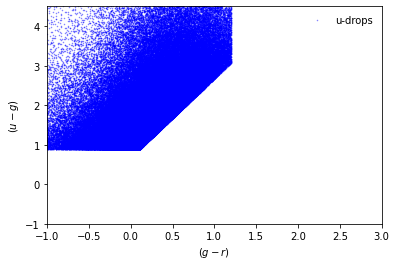

In [34]:
pl.plot(udrops['g'] - udrops['r'], udrops['u'] - udrops['g'], marker='.', c='b', lw=0.0, label='u-drops', alpha=0.5, markersize=1)

pl.xlim(-1., 3.0)
pl.ylim(-1., 4.5)

pl.xlabel(r'$(g-r)$')
pl.ylabel(r'$(u-g)$')

pl.legend(frameon=False)

pl.savefig('plots/Feb21/clauds-udrop-color-selection.pdf')

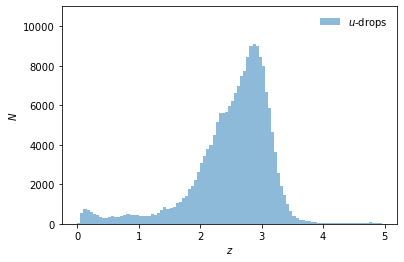

In [35]:
bins = np.arange(0.0, 5.0, 0.05)

pl.hist(udrops['Z_BEST'], bins=bins, alpha=0.5, label='$u$-drops')

pl.ylim(0.0, 1.1e4)

pl.xlabel(r'$z$')
pl.ylabel(r'$N$')

pl.legend(frameon=False)

In [36]:
zmax       = 1.5

interloper = udrops[udrops['Z_BEST'] < zmax]
highz      = udrops[udrops['Z_BEST'] > zmax]

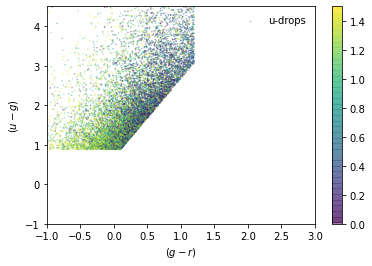

In [37]:
pl.scatter(interloper['g'] - interloper['r'], interloper['u'] - interloper['g'], marker='.', c=interloper['Z_BEST'], alpha=0.5, label='u-drops', vmin=0.0, vmax=zmax, s=1)

pl.xlim(-1., 3.0)
pl.ylim(-1., 4.5)

pl.xlabel(r'$(g-r)$')
pl.ylabel(r'$(u-g)$')

pl.colorbar()

pl.legend(frameon=False)

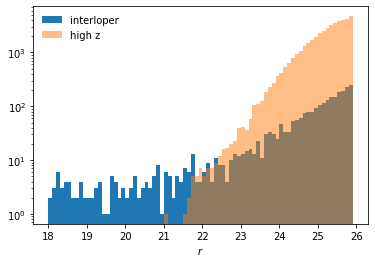

In [38]:
bins = np.arange(18., 26., 0.1)

pl.hist(interloper['r'], bins=bins, label='interloper')
pl.hist(     highz['r'], bins=bins, alpha=0.5, label='high z')

pl.yscale('log')
pl.xlabel(r'$r$')

pl.legend(frameon=False)

In [39]:
rlim_udrops = clauds[liu_udrops(clauds, band='r', magmin=19., maglim=26.)]

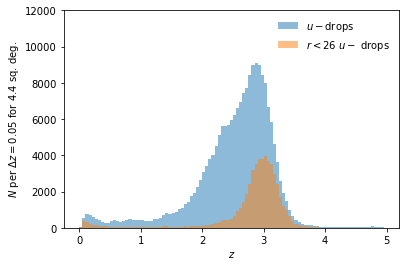

In [40]:
dz          = 0.05
bins        = np.arange(0.0, 5.0, dz)

pl.hist(udrops['Z_BEST'], bins=bins, alpha=0.5, label=r'$u-$drops')
pl.hist(rlim_udrops['Z_BEST'], bins=bins, alpha=0.5, label=r'$r<26$ $u-$ drops')

pl.ylim(0.0, 1.2e4)

pl.xlabel(r'$z$')
pl.ylabel(r'$N$ per $\Delta z={:.2f}$ for {:.1f} sq. deg.'.format(dz, area['u']))

pl.legend(frameon=False)

pl.savefig('plots/Feb21/clauds-udrop-redshift-distribution.pdf')

In [41]:
print('Target density of u-dropouts per sq. deg. is {:.2f}'.format(len(rlim_udrops) / area['u']))

Target density of u-dropouts per sq. deg. is 11691.16


In [42]:
print('u-dropout interloper percentage of {:.3f}'.format(100. * np.count_nonzero(rlim_udrops['ZPHOT'] < 1.5) / len(rlim_udrops)))

u-dropout interloper percentage of 5.429


In [43]:
def flatmagcat(maglimcat, band, maglim=26.01, debug=False):
    bins       = np.arange(20., maglim, 0.1)
    
    assert  maglimcat[band].max() <= maglim
    
    result     = np.histogram(maglimcat[band], bins=bins)

    cnts, bins = result[0], result[1]
    lims       = bins[:-1]
     
    cut        = cnts > 0.25 * np.median(cnts[cnts > 0])
    cutlim     = lims[cut][0]
        
    magsampling                    = cnts / cnts[cut][0]    
    magsampling[(magsampling < 1.) & (bins[:-1] < cutlim)] = 1.0
    
    if debug:
        print(magsampling)
    
    magsampling                    = 1. / magsampling
        
    magsampling                = np.concatenate((magsampling, np.array([0])))
        
    indx                       = np.digitize(maglimcat[band], bins)
    
    sampling                   = np.random.uniform(0.0, 1.0, len(maglimcat))
    
    maglimcat['ISIN']          = sampling < magsampling[indx]
        
    # In, residual.
    return  cutlim, maglimcat[maglimcat['ISIN']], maglimcat[~maglimcat['ISIN']]

In [44]:
def qa(tiers, band, area):
    upriority, cnts = np.unique(tiers['PRIORITY'].data, return_counts=True)

    for p, c in zip(upriority[::-1], cnts[::-1]):
        magmin      = tiers[tiers['PRIORITY'] == p][band].min()
        
        meanmag     = np.mean(tiers[tiers['PRIORITY'] == p][band])
        meanz       = np.mean(tiers[tiers['PRIORITY'] == p]['Z_BEST'])
        
        quarter     = np.percentile(tiers[tiers['PRIORITY'] == p]['Z_BEST'].compressed(), 25, axis=0)
        medianz     = np.median(tiers[tiers['PRIORITY'] == p]['Z_BEST'].compressed())
        tquarter    = np.percentile(tiers[tiers['PRIORITY'] == p]['Z_BEST'].compressed(), 75, axis=0)   
        
        loper_rate  = 100. * np.count_nonzero(tiers[tiers['PRIORITY'] == p]['Z_BEST'] < 1.5) / len(tiers[tiers['PRIORITY'] == p]) 
        
        print('{: 10d} \t {: .1f} per sq. deg. \t {:.2f} \t {:.2f} \t {:.2f} \t ({:.2f} \t {:.2f} \t {:.2f}) \t {:.2f}% z < 1.5 contamination'.format(p, c / area, magmin, meanmag, meanz, quarter, medianz, tquarter, loper_rate))

In [57]:
def reduce(start_id, inputcat, band, ttype, area, maglim=26.1, levels=10, max_inpriority=500, priority_shift=0, reprioritise=True, write=False, debug=False):
    bins = np.arange(18., maglim, 0.1)
    result = pl.hist(inputcat[band], bins=bins, alpha=0.3)
    reducecat = Table(inputcat, copy=True)

    tiers = Table()
    total =  0

    for i in np.arange(levels):    
        priority                = 1000 * (levels - i) + priority_shift
        
        cutlim, flat_drops, reducecat = flatmagcat(reducecat, band, debug=debug, maglim=maglim)
        
        flat_drops['PRIORITY'] = priority
                    
        tiers                   = vstack((tiers, flat_drops))
    
        total                  += len(flat_drops)
    
        string = '{:.1f} \t {} \t {:d}'.format(cutlim, len(np.unique(tiers['PRIORITY'].data)), np.count_nonzero(tiers['PRIORITY'] == priority))

        # Reshuffle such that there's a max of 1000 to a priority class.
        # Move remaining to a lower tier.
        if np.count_nonzero(tiers['PRIORITY'] == priority) > max_inpriority:
            is_priority        = tiers['PRIORITY'] == priority

            n_priority         = np.cumsum(is_priority)

            is_priority[n_priority < (1 + max_inpriority)] = False  
        
            string += '\tAdjusting {:d} entries.'.format(len(tiers['PRIORITY'][is_priority]))
        
            if reprioritise:
                tiers['PRIORITY'][is_priority] -= 1000
    
            else:
                tiers['PRIORITY'][is_priority]  = -tiers['PRIORITY'][is_priority] 
    
        print(string)
        print('{:.1f} \t {} \t {:d}\n'.format(cutlim, len(np.unique(tiers['PRIORITY'].data)), np.count_nonzero(tiers['PRIORITY'] == priority)))
    
        result = pl.hist(tiers[tiers['PRIORITY'] == priority][band], bins=bins, alpha=0.25, label='PRIORITY {}'.format(priority))
    
    print('\n-------------------------\n')
    print('{} \t {}'.format(total, len(inputcat)))

    pl.xlim(18., 26.1)

    pl.xlabel(r'${}$'.format(band))
    pl.ylabel(r'$N$')

    pl.yscale('log')

    pl.legend(frameon=False, ncol=2)
    pl.title(r'${}$-drop'.format(ttype))
    pl.savefig('plots/Feb21/clauds-{}drop-magnitude-distribution.pdf'.format(ttype))
    
    isin, indx            = is_point_in_desi(tiles, tiers['RA'], tiers['DEC'], radius=None, return_tile_index=True)

    tiers['TILEID']       = tiles['TILEID'][indx]
    
    tiers['SAMPLE']       = 'CLAUDS-{}'.format(ttype.upper())
    tiers['TARGETID']     = start_id + np.arange(len(tiers))
    tiers['SUBPRIORITY']  = np.random.uniform(0.0, 1.0, len(tiers))

    tiers['PMRA']         = np.zeros(len(tiers),   dtype='>f4')
    tiers['PMDEC']        = np.zeros(len(tiers),   dtype='>f4')

    tiers['REF_EPOCH']    = np.zeros(len(tiers),   dtype='>f4')
    tiers['OVERRIDE']     = np.zeros(len(tiers),   dtype='>f4')

    tiers.meta['EXTNAME'] = 'MTL'

    del tiers['ISIN']
    
    if write:
        Path('/global/cscratch1/sd/mjwilson/DESILBG/Feb21/targets/{}drops/'.format(ttype)).mkdir(parents=True, exist_ok=True)
        
        upriorities = np.unique(tiers['PRIORITY'])
        
        for up in upriorities:
            ptiers  = tiers[tiers['PRIORITY'] == up] 
            ptiers.write('/global/cscratch1/sd/mjwilson/DESILBG/Feb21/targets/{}drops/{}drops-{}.fits'.format(ttype, ttype, str(up).replace('-','m')), format='fits', overwrite=True)

    print('\n\n')
            
    qa(tiers, band, area)
        
    print('\n\n')
        
    return tiers

21.7 	 1 	 746	Adjusting 246 entries.
21.7 	 2 	 500

23.6 	 3 	 4480	Adjusting 3980 entries.
23.6 	 4 	 500

24.1 	 5 	 6761	Adjusting 6261 entries.
24.1 	 6 	 500

24.4 	 7 	 6734	Adjusting 6234 entries.
24.4 	 8 	 500

24.7 	 9 	 7521	Adjusting 7021 entries.
24.7 	 10 	 500

24.9 	 11 	 5573	Adjusting 5073 entries.
24.9 	 12 	 500

25.0 	 13 	 2956	Adjusting 2456 entries.
25.0 	 14 	 500

25.1 	 15 	 2243	Adjusting 1743 entries.
25.1 	 16 	 500

25.2 	 17 	 2228	Adjusting 1728 entries.
25.2 	 18 	 500

25.3 	 19 	 1649	Adjusting 1149 entries.
25.3 	 20 	 500

25.4 	 21 	 1042	Adjusting 542 entries.
25.4 	 22 	 500

25.5 	 23 	 880	Adjusting 380 entries.
25.5 	 24 	 500

25.6 	 25 	 738	Adjusting 238 entries.
25.6 	 26 	 500

25.7 	 27 	 757	Adjusting 257 entries.
25.7 	 28 	 500

25.7 	 29 	 262
25.7 	 29 	 262

25.8 	 30 	 736	Adjusting 236 entries.
25.8 	 31 	 500

25.8 	 32 	 213
25.8 	 32 	 213

25.8 	 33 	 130
25.8 	 33 	 130

25.9 	 34 	 700	Adjusting 200 entries.
25.9 	 35 	 

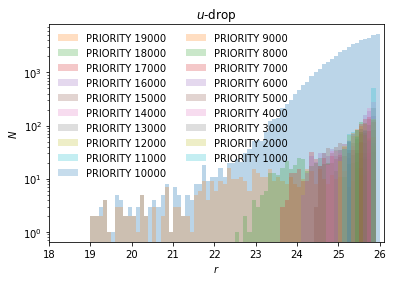

In [47]:
utiers = reduce(0, rlim_udrops, 'r', 'u', area['u'], reprioritise=False, maglim=26.01, levels=19, write=True)

# BX selection

In [48]:
def bx(cat, rmin=19., rmax=24.5):
    # https://arxiv.org/pdf/0903.3951.pdf    
    isin = np.ones(len(cat), dtype=bool)

    cat['u-g'] = cat['u'] - cat['g']
    cat['g-r'] = cat['g'] - cat['r']
    
    # LATIS, https://arxiv.org/pdf/2002.10676.pdf
    # 0.5 < u − g < 2.2 and −0.1 < g − r < 1.0 and u − g > 0.50 + 2.3(g − r − 0.35).
    isin &= cat['u-g'] >  0.0
    isin &= cat['u-g'] <  3.0
    isin &= cat['g-r'] > -0.5
    isin &= cat['g-r'] <  1.0
    isin &= cat['u-g'] >  1.0 + 2.3 * (cat['g-r'] - 0.35)

    # isin &= ((cat['g-r'] < 0.25) & (cat['u-g'] < 1.2)) | (cat['u-g'] >= 1.2)
    # isin &= ((cat['g-r'] < 0.15) & (cat['u-g'] < 1.0)) | (cat['u-g'] >= 1.0)
    
    isin  = isin & (cat['r'] > rmin)
    isin  = isin & (cat['r'] < rmax)
    isin  = isin & (~liu_udrops(cat, band='r', magmin=rmin, maglim=rmax))

    # Catch -99 for ill defined magnitudes
    isin = isin & (cat['u'] > 0.0)
    isin = isin & (cat['g'] > 0.0)
    
    return  isin

In [49]:
# not u-drops, by definition.
bx_clauds = clauds[bx(clauds, rmin=19., rmax=24.5)]

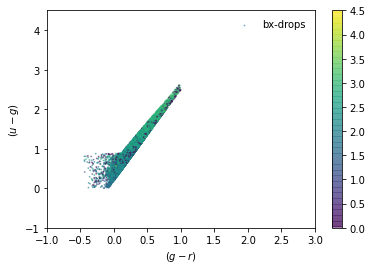

In [50]:
pl.scatter(bx_clauds['g'] - bx_clauds['r'], bx_clauds['u'] - bx_clauds['g'], marker='.', c=bx_clauds['Z_BEST'], alpha=0.5, label='bx-drops', vmin=0.0, vmax=4.5, s=3)

pl.xlim(-1., 3.0)
pl.ylim(-1., 4.5)

pl.xlabel(r'$(g-r)$')
pl.ylabel(r'$(u-g)$')

pl.colorbar()

pl.legend(frameon=False)

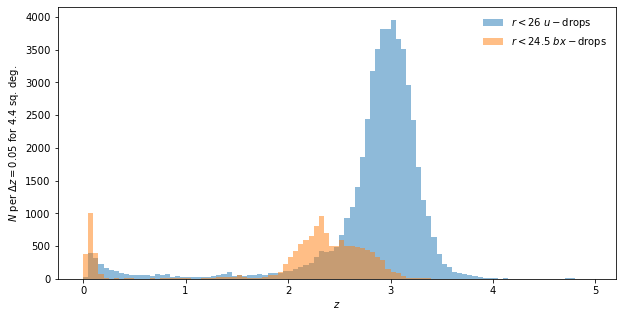

In [51]:
fig, axes = plt.subplots(1, 1, figsize=(10., 5.))
    
dz   = 0.05
bins = np.arange(0.0, 5.0, dz)

axes.hist(rlim_udrops['Z_BEST'], bins=bins, alpha=0.5, label=r'$r<26$ $u-$drops')
axes.hist(bx_clauds['Z_BEST'], bins=bins, alpha=0.5, label=r'$r<24.5$ $bx-$drops')

axes.set_xlabel(r'$z$')
axes.set_ylabel(r'$N$ per $\Delta z={:.2f}$ for {:.1f} sq. deg.'.format(dz, area['u']))

axes.legend(frameon=False)

In [52]:
print('Target density of bx-dropouts per sq. deg. is {:.2f}'.format(len(bx_clauds) / area['u']))

Target density of bx-dropouts per sq. deg. is 3018.14


In [53]:
bx_interlopers = bx_clauds[bx_clauds['ZPHOT'] < 0.1]

In [54]:
print('BX interloper percentage of {:.3f}'.format(100. * np.count_nonzero(bx_clauds['ZPHOT'] < 0.1) / len(bx_clauds)))

BX interloper percentage of 11.232


In [55]:
start_id = len(utiers)
start_id

46349

20.0 	 1 	 1507	Adjusting 1007 entries.
20.0 	 2 	 500

21.6 	 3 	 408
21.6 	 3 	 408

22.7 	 4 	 560	Adjusting 60 entries.
22.7 	 5 	 500

23.1 	 6 	 1177	Adjusting 677 entries.
23.1 	 7 	 500

23.4 	 8 	 1399	Adjusting 899 entries.
23.4 	 9 	 500

23.6 	 10 	 1562	Adjusting 1062 entries.
23.6 	 11 	 500

23.7 	 12 	 1049	Adjusting 549 entries.
23.7 	 13 	 500

23.8 	 14 	 639	Adjusting 139 entries.
23.8 	 15 	 500

23.9 	 16 	 580	Adjusting 80 entries.
23.9 	 17 	 500

24.0 	 18 	 681	Adjusting 181 entries.
24.0 	 19 	 500

24.1 	 20 	 488
24.1 	 20 	 488

24.2 	 21 	 434
24.2 	 21 	 434

24.2 	 22 	 122
24.2 	 22 	 122

24.3 	 23 	 298
24.3 	 23 	 298

24.3 	 24 	 73
24.3 	 24 	 73

24.3 	 25 	 55
24.3 	 25 	 55


-------------------------

11032 	 13310



     19000 	  113.4 per sq. deg. 	 19.00 	 21.93 	 0.42 	 (0.07 	 0.10 	 2.30) 	 61.20% z < 1.5 contamination
     18000 	  92.5 per sq. deg. 	 20.03 	 22.82 	 0.75 	 (0.09 	 2.14 	 2.48) 	 40.69% z < 1.5 contamination
     17000

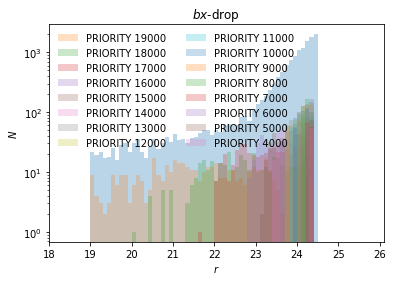

In [58]:
bxtiers = reduce(start_id, bx_clauds, 'r', 'bx', area['u'], levels=16, priority_shift=3000, maglim=24.51, reprioritise=False, debug=False, write=True)

In [60]:
bxtiers[bxtiers['PRIORITY'] >= 0]

ID,RA,DEC,TRACT,PATCH,MASK,FLAG_FIELD,FLAG_FIELD_BINARY [5],A_WORLD,B_WORLD,KRON_RADIUS,THETA_WORLD,ELONGATION,ELLIPTICITY,EB_V,FWHM_WORLD_HSC_I,MU_MAX_HSC_I,CLASS_STAR_HSC_I,FLUX_RADIUS_0.25_HSC_I,FLUX_RADIUS_0.5_HSC_I,FLUX_RADIUS_0.75_HSC_I,FUV,NUV,u,uS,g,r,i,z,y,Yv,J,H,Ks,FUV_err,NUV_err,u_err,uS_err,g_err,r_err,i_err,z_err,y_err,Yv_err,J_err,H_err,Ks_err,MAG_APER_2s_u,MAG_APER_2s_uS,MAG_APER_2s_g,MAG_APER_2s_r,MAG_APER_2s_i,MAG_APER_2s_z,MAG_APER_2s_y,MAG_APER_2s_Yv,MAG_APER_2s_J,MAG_APER_2s_H,MAG_APER_2s_Ks,MAGERR_APER_2s_u,MAGERR_APER_2s_uS,MAGERR_APER_2s_g,MAGERR_APER_2s_r,MAGERR_APER_2s_i,MAGERR_APER_2s_z,MAGERR_APER_2s_y,MAGERR_APER_2s_Yv,MAGERR_APER_2s_J,MAGERR_APER_2s_H,MAGERR_APER_2s_Ks,MAG_APER_3s_u,MAG_APER_3s_uS,MAG_APER_3s_g,MAG_APER_3s_r,MAG_APER_3s_i,MAG_APER_3s_z,MAG_APER_3s_y,MAG_APER_3s_Yv,MAG_APER_3s_J,MAG_APER_3s_H,MAG_APER_3s_Ks,MAGERR_APER_3s_u,MAGERR_APER_3s_uS,MAGERR_APER_3s_g,MAGERR_APER_3s_r,MAGERR_APER_3s_i,MAGERR_APER_3s_z,MAGERR_APER_3s_y,MAGERR_APER_3s_Yv,MAGERR_APER_3s_J,MAGERR_APER_3s_H,MAGERR_APER_3s_Ks,OFFSET_MAG_2s,OFFSET_MAG_3s,CONTEXT,MAG_ABS_FUV,MAG_ABS_NUV,MAG_ABS_u,MAG_ABS_uS,MAG_ABS_g,MAG_ABS_r,MAG_ABS_i,MAG_ABS_z,MAG_ABS_y,MAG_ABS_Yv,MAG_ABS_J,MAG_ABS_H,MAG_ABS_Ks,Z_SPEC,Z_BEST,Z_BEST68_LOW,Z_BEST68_HIGH,NBAND_USED,CHI_BEST,CHI_STAR,CHI_QSO,MOD_BEST,MOD_STAR,MOD_QSO,Z_ML,Z_ML68_LOW,Z_ML68_HIGH,Z_SEC,Z_QSO,Z_BC03,ZPHOT,MOD_BEST_BC03,AGE_BEST,EBV_BEST,EXTLAW_BEST,AGE_MED,MASS_MED,MASS_BEST,MASS_INF,MASS_SUP,SFR_MED,SFR_BEST,SFR_INF,SFR_SUP,SSFR_MED,SSFR_BEST,SSFR_INF,SSFR_SUP,LUM_NUV_BEST,LUM_R_BEST,LUM_K_BEST,OBJ_TYPE,COMPACT,STAR_FORMING,NrK,IRX_NrK,LIR_NrK,SFR_NrK,u-g,g-r,PRIORITY,TILEID,SAMPLE,TARGETID,SUBPRIORITY,PMRA,PMDEC,REF_EPOCH,OVERRIDE
int64,float64,float64,int64,bytes3,int16,int16,bool,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,int64,int32,str9,int64,float64,float32,float32,float32,float32
2680362,150.5640898044576,1.060884778316955,9571,"7,6",0,3,True .. False,0.00015113335,0.00014769929,4.0,-56.539272,1.0232868,0.022756882,0.021017490578430307,0.00017296102,20.86546,0.9862529,0.8441919,1.2565919,1.6244657,-99.0,-99.0,22.547,22.353,21.699,21.428,21.303,21.244,21.293,-99.025,-99.018,-99.012,-99.008,-99.0,-99.0,0.002,0.016,0.002,0.002,0.002,0.003,0.007,1000.0,1000.0,1000.0,1000.0,22.80993,22.613277,21.938229,21.646442,21.507034,21.437614,21.482292,-99.0,-99.0,-99.0,-99.0,0.0024261475,0.015655518,0.0015916824,0.0018053055,0.0019350052,0.0028915405,0.007232666,1000.0,1000.0,1000.0,1000.0,22.651075,22.470413,21.816366,21.530376,21.424553,21.376913,21.388601,-99.0,-99.0,-99.0,-99.0,0.0029449463,0.019241333,0.0019893646,0.0023326874,0.0026302338,0.0040397644,0.009902954,1000.0,1000.0,1000.0,1000.0,-0.16204385951727934,-0.04849420667058429,2047.0,-14.303,-14.244,-14.86,-15.042,-15.423,-15.637,-15.77,-15.748,-15.795,-15.804,-15.81,-15.914,-15.646,0.0589,0.0589,-99.0,-99.0,11,39.3174,66.2032,6

# Goldrush g-dropouts

In [59]:
clauds_hsc, area = get_clauds(imaging_bit=0, field='COSMOS')

In [62]:
def gdrop(cat, imin=18., imax=26.):
    # https://arxiv.org/pdf/0903.3951.pdf    
    isin  = np.ones(len(cat), dtype=bool)

    cat['r-i'] = cat['r'] - cat['i']
    cat['g-r'] = cat['g'] - cat['r']

    # https://arxiv.org/pdf/1704.06004.pdf
    isin &= cat['g-r'] >  1.0
    isin &= cat['r-i'] <  1.0    
    isin &= cat['g-r'] >  1.5 * cat['r-i'] + 0.8
    
    isin  = isin & (cat['i'] > imin)
    isin  = isin & (cat['i'] < imax)
    
    # Catch -99 for ill defined magnitudes
    isin = isin & (cat['g'] > 0.0)
    isin = isin & (cat['r'] > 0.0)
    isin = isin & (cat['i'] > 0.0)
    
    # Exclude where we have u imaging
    # isin = isin & (cat['FLAG_FIELD_BINARY'][:,1] == False)
        
    return  isin

In [60]:
clauds_hsc

ID,RA,DEC,TRACT,PATCH,MASK,FLAG_FIELD,FLAG_FIELD_BINARY [5],A_WORLD,B_WORLD,KRON_RADIUS,THETA_WORLD,ELONGATION,ELLIPTICITY,EB_V,FWHM_WORLD_HSC_I,MU_MAX_HSC_I,CLASS_STAR_HSC_I,FLUX_RADIUS_0.25_HSC_I,FLUX_RADIUS_0.5_HSC_I,FLUX_RADIUS_0.75_HSC_I,FUV,NUV,u,uS,g,r,i,z,y,Yv,J,H,Ks,FUV_err,NUV_err,u_err,uS_err,g_err,r_err,i_err,z_err,y_err,Yv_err,J_err,H_err,Ks_err,MAG_APER_2s_u,MAG_APER_2s_uS,MAG_APER_2s_g,MAG_APER_2s_r,MAG_APER_2s_i,MAG_APER_2s_z,MAG_APER_2s_y,MAG_APER_2s_Yv,MAG_APER_2s_J,MAG_APER_2s_H,MAG_APER_2s_Ks,MAGERR_APER_2s_u,MAGERR_APER_2s_uS,MAGERR_APER_2s_g,MAGERR_APER_2s_r,MAGERR_APER_2s_i,MAGERR_APER_2s_z,MAGERR_APER_2s_y,MAGERR_APER_2s_Yv,MAGERR_APER_2s_J,MAGERR_APER_2s_H,MAGERR_APER_2s_Ks,MAG_APER_3s_u,MAG_APER_3s_uS,MAG_APER_3s_g,MAG_APER_3s_r,MAG_APER_3s_i,MAG_APER_3s_z,MAG_APER_3s_y,MAG_APER_3s_Yv,MAG_APER_3s_J,MAG_APER_3s_H,MAG_APER_3s_Ks,MAGERR_APER_3s_u,MAGERR_APER_3s_uS,MAGERR_APER_3s_g,MAGERR_APER_3s_r,MAGERR_APER_3s_i,MAGERR_APER_3s_z,MAGERR_APER_3s_y,MAGERR_APER_3s_Yv,MAGERR_APER_3s_J,MAGERR_APER_3s_H,MAGERR_APER_3s_Ks,OFFSET_MAG_2s,OFFSET_MAG_3s,CONTEXT,MAG_ABS_FUV,MAG_ABS_NUV,MAG_ABS_u,MAG_ABS_uS,MAG_ABS_g,MAG_ABS_r,MAG_ABS_i,MAG_ABS_z,MAG_ABS_y,MAG_ABS_Yv,MAG_ABS_J,MAG_ABS_H,MAG_ABS_Ks,Z_SPEC,Z_BEST,Z_BEST68_LOW,Z_BEST68_HIGH,NBAND_USED,CHI_BEST,CHI_STAR,CHI_QSO,MOD_BEST,MOD_STAR,MOD_QSO,Z_ML,Z_ML68_LOW,Z_ML68_HIGH,Z_SEC,Z_QSO,Z_BC03,ZPHOT,MOD_BEST_BC03,AGE_BEST,EBV_BEST,EXTLAW_BEST,AGE_MED,MASS_MED,MASS_BEST,MASS_INF,MASS_SUP,SFR_MED,SFR_BEST,SFR_INF,SFR_SUP,SSFR_MED,SSFR_BEST,SSFR_INF,SSFR_SUP,LUM_NUV_BEST,LUM_R_BEST,LUM_K_BEST,OBJ_TYPE,COMPACT,STAR_FORMING,NrK,IRX_NrK,LIR_NrK,SFR_NrK
int64,float64,float64,int64,bytes3,int16,int16,bool,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64
3046043,149.37283871619073,2.7749719222265194,9812,"1,7",0,31,True .. True,0.00012951162,8.410009e-05,4.580202,19.53145,1.5402645,0.35076082,0.015815162527130396,0.0006257708,25.824585,0.042167876,0.5937541,0.86615753,1.0631003,-99.0,-99.0,27.734,-99.074,26.35,26.184,26.078,27.399,29.304,25.152,25.167,25.525,25.896,-99.0,-99.0,0.489,-99.0,0.161,0.192,0.202,1.114,14.688,0.105,0.137,0.245,0.487,28.434986,99.0,27.032373,26.851809,26.73393,28.04834,29.949114,25.796309,25.80563,26.158484,26.526714,0.4885254,-99.0,0.16137695,0.19165039,0.20202637,1.1142578,14.6875,0.10510254,0.13684082,0.24523926,0.48657227,29.067602,99.0,27.01321,27.310604,27.107258,99.0,99.0,25.381588,25.068941,25.748484,25.124016,1.3085938,-99.0,0.2364502,0.4387207,0.4267578,-99.0,-99.0,0.10772705,0.10418701,0.25219727,0.20056152,-0.6249656673680196,-0.024291831260653436,2045.0,-13.75,-14.96,-15.762,-15.487,-15.814,-16.753,-16.757,-16.927,-17.006,-17.029,-17.099,-17.175,-16.916,0.5056,0.5056,-99.0,-99.0,10,16.6411,24.4545,16.5138,10,141,6,-99.0,-99.0,-99.0,-99.0,0.08,0.5056,0.5056,10,50000000.0,0.5,2,307712000.0,7.55696,7.25749,7.34355,7.7837,-0.680038,-0.0833177,-0.992291,-0.40928,-8.20471,-7

In [63]:
ilim_gdrops = clauds_hsc[gdrop(clauds_hsc, imax=26.)]

In [64]:
len(clauds_hsc) / 1.e6

3.696114

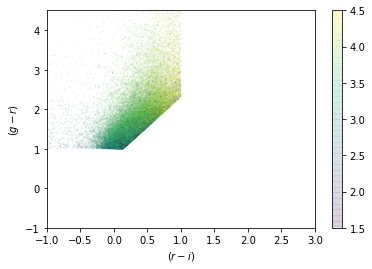

In [65]:
pl.scatter(ilim_gdrops['r'] - ilim_gdrops['i'], ilim_gdrops['g'] - ilim_gdrops['r'], marker='.', c=ilim_gdrops['Z_BEST'], alpha=0.1, label='', vmin=zmax, vmax=4.5, s=1)

pl.xlim(-1., 3.0)
pl.ylim(-1., 4.5)

pl.xlabel(r'$(r-i)$')
pl.ylabel(r'$(g-r)$')

pl.colorbar()

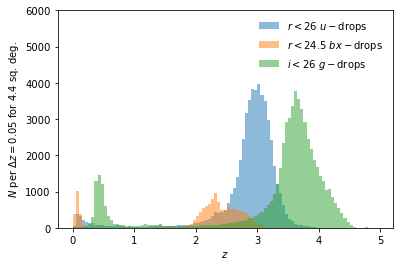

In [66]:
dz   = 0.05
bins = np.arange(0.0, 5.0, dz)

pl.hist(rlim_udrops['Z_BEST'], bins=bins, alpha=0.5, label=r'$r<26$ $u-$drops')
pl.hist(bx_clauds['Z_BEST'], bins=bins, alpha=0.5, label=r'$r<24.5$ $bx-$drops')
pl.hist(ilim_gdrops['Z_BEST'], bins=bins, alpha=0.5, label=r'$i<26 \ g-$drops')

pl.ylim(0.0, 6.e3)

pl.xlabel(r'$z$')
pl.ylabel(r'$N$ per $\Delta z={:.2f}$ for {:.1f} sq. deg.'.format(dz, area['u']))

pl.legend(frameon=False)

In [67]:
print('Target density of g-dropouts per sq. deg. is {:.2f}'.format(len(ilim_gdrops) / area['g']))

Target density of g-dropouts per sq. deg. is 7410.08


In [68]:
print('g-drop interloper percentage of {:.3f}'.format(100. * np.count_nonzero(ilim_gdrops['Z_BEST'] < 1.0) / len(ilim_gdrops)))

g-drop interloper percentage of 10.633


In [69]:
start_id = 1 + bxtiers['TARGETID'].max()
start_id

57381

21.7 	 1 	 510
21.7 	 1 	 510

23.6 	 2 	 3113	Adjusting 2113 entries.
23.6 	 3 	 1000

24.3 	 4 	 9377	Adjusting 8377 entries.
24.3 	 5 	 1000

24.6 	 6 	 8217	Adjusting 7217 entries.
24.6 	 7 	 1000

24.8 	 8 	 6847	Adjusting 5847 entries.
24.8 	 9 	 1000

25.0 	 10 	 6786	Adjusting 5786 entries.
25.0 	 11 	 1000

25.1 	 12 	 3542	Adjusting 2542 entries.
25.1 	 13 	 1000

25.2 	 14 	 2776	Adjusting 1776 entries.
25.2 	 15 	 1000

25.3 	 16 	 2680	Adjusting 1680 entries.
25.3 	 17 	 1000

25.4 	 18 	 1713	Adjusting 713 entries.
25.4 	 19 	 1000

25.5 	 20 	 1442	Adjusting 442 entries.
25.5 	 21 	 1000

25.6 	 22 	 1072	Adjusting 72 entries.
25.6 	 23 	 1000

25.7 	 24 	 970
25.7 	 24 	 970

25.7 	 25 	 284
25.7 	 25 	 284

25.8 	 26 	 903
25.8 	 26 	 903


-------------------------

50232 	 58095



     15000 	  65.1 per sq. deg. 	 18.04 	 23.53 	 2.48 	 (0.47 	 3.56 	 3.84) 	 32.35% z < 1.5 contamination
     14000 	  127.6 per sq. deg. 	 22.25 	 24.55 	 2.99 	 (3.39 	 3.61 	 3.84) 

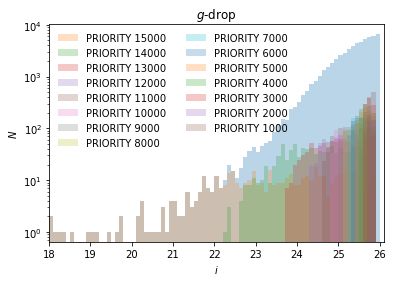

In [70]:
gtiers = reduce(start_id, ilim_gdrops, 'i', 'g', area['g'], max_inpriority=1000, priority_shift=0, maglim=26.01, reprioritise=False, levels=15, debug=False, write=True)

In [71]:
len(gtiers[gtiers['PRIORITY'] >= 0])

13667

Text(0.5, 1.0, 'Clauds COSMOS: (150.1388, 2.2112)')

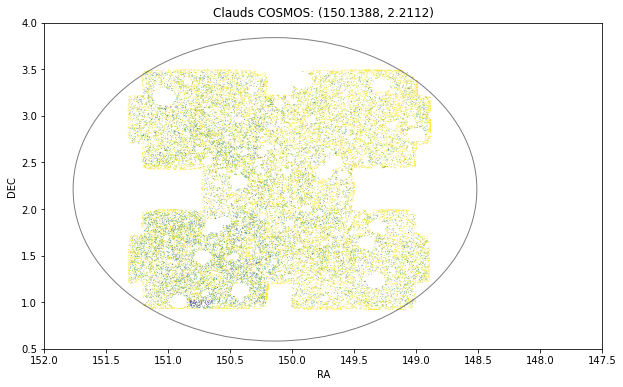

In [72]:
fig, ax  = plt.subplots(1, 1, figsize=(10, 6)) 
im       = pl.scatter(utiers['RA'], utiers['DEC'], c=utiers['u_err'], marker='.', s=2, lw=0.0, vmin=0.0, vmax=.25)

for ind in tileids:    
    circles(cra, cdec, trad, c='k', fc="None", alpha=0.5)
    
    break
    
ax.set_xlim(152., 147.5)
ax.set_ylim( 0.5,   4.0)

ax.set_xlabel('RA')
ax.set_ylabel('DEC')

# cax      = fig.add_axes([0.15, 0.2, 0.2, 0.05])
# fig.colorbar(im, cax=cax, orientation='horizontal')

ax.set_title('Clauds COSMOS: ({:.4f}, {:.4f})'.format(cra, cdec))

Text(0.5, 1.0, 'Clauds COSMOS: (150.1388, 2.2112)')

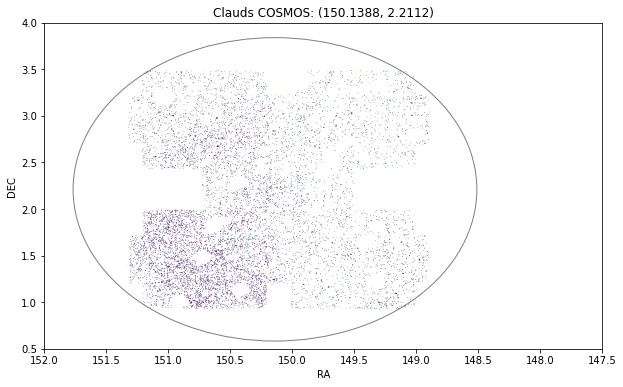

In [75]:
fig, ax  = plt.subplots(1, 1, figsize=(10, 6)) 
im       = pl.scatter(bxtiers['RA'], bxtiers['DEC'], c=bxtiers['u_err'], marker='.', s=2, lw=0.0, vmin=0.0, vmax=.25)

for ind in tileids:    
    circles(cra, cdec, trad, c='k', fc="None", alpha=0.5)
    
    break
    
ax.set_xlim(152., 147.5)
ax.set_ylim( 0.5,   4.0)

ax.set_xlabel('RA')
ax.set_ylabel('DEC')

ax.set_title('Clauds COSMOS: ({:.4f}, {:.4f})'.format(cra, cdec))

Text(0.5, 1.0, 'Clauds COSMOS: (150.1388, 2.2112)')

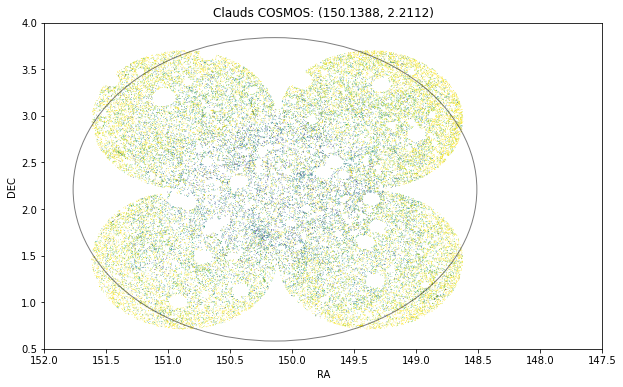

In [76]:
fig, ax  = plt.subplots(1, 1, figsize=(10, 6)) 
im       = pl.scatter(gtiers['RA'], gtiers['DEC'], c=gtiers['g_err'], marker='.', s=2, lw=0.0, vmin=0.0, vmax=.25)

for ind in tileids:    
    circles(cra, cdec, trad, c='k', fc="None", alpha=0.5)
    
    break
    
ax.set_xlim(152., 147.5)
ax.set_ylim( 0.5,   4.0)

ax.set_xlabel('RA')
ax.set_ylabel('DEC')

ax.set_title('Clauds COSMOS: ({:.4f}, {:.4f})'.format(cra, cdec))

# Done.